In [2]:
import pandas as pd
import numpy as np
import sklearn
#import xgboost as xgb
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('Case Study data.xlsx')
columns = df.columns.values
df.head(3)


,ID,Age_Band,Segment,Mosaic_Group,NCD,Vehicle_Value,Vehicle_Manufacturer,BrandA_Price,BrandA_Rank,BrandA_Selected,BrandB_Price,BrandB_Rank,BrandB_Selected,BrandC_Price,BrandC_Rank,BrandC_Selected
0,1,25-34,A,Aspiring Homemakers,2 Years,3000-4999,Ford,1219.31,47,0,1111.53,32,0,1356.79,53,0
1,2,45-54,B,Domestic Success,9 Years,10000-14999,Mini,213.65,24,0,205.95,15,0,321.44,65,0
2,3,45-54,B,Domestic Success,9 Years,10000-14999,Mini,224.40,24,0,216.70,18,0,340.61,66,0


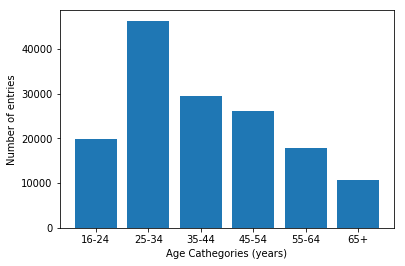

In [4]:
# Turn features that are segmented into cathegorical variables
ageCathegories = df['Age_Band'].unique()
ageCathegories.sort()

# Turn features that are discrete into cathegorical variables
map_ageCat = {ageCathegories[i]:i for i in range(len(ageCathegories))}
df['ageCategories'] = df['Age_Band'].map(map_ageCat)
columnsForTrain = ['ageCategories']
del map_ageCat

hist_age = {ageCathegories[i]:len(df.loc[df['Age_Band'] == ageCathegories[i]]) for i in range(len(ageCathegories))}

plt.bar(hist_age.keys(), hist_age.values())
plt.xlabel('Age Cathegories (years)')
plt.ylabel('Number of entries')
plt.savefig('HistogramOfAgeCat.png')

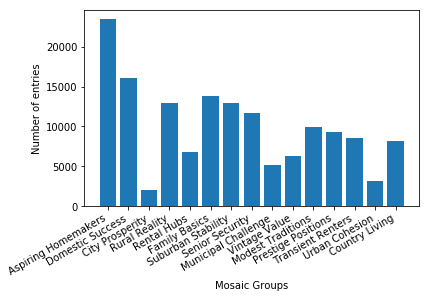

In [5]:
MosaicCat = df['Mosaic_Group'].unique()
# Because there are 'NaN' entries in the Mosaic_Group column, need to exclude last element from
# the list of unique values of Mosaic_Group
MosaicCat = MosaicCat[0:len(MosaicCat)-1]
# This column contains NaNs. Their number is small, so one way to deal with them is to generate
# random values from the MosaicCat to fill the NaNs
# Fill the NaNs in the Mosaic_Group column with random values from the list of unique values this feature gets
from random import choices
df['Mosaic_Group'].fillna(pd.Series(choices(MosaicCat, k = len(df))),inplace=True)
df.isna().sum()

# Turn features that are discrete into cathegorical variables
map_MosaicCat = {MosaicCat[i]:i for i in range(len(MosaicCat))}
df['MosaicCat'] = df['Mosaic_Group'].map(map_MosaicCat)
columnsForTrain.append('MosaicCat')
del map_MosaicCat

hist_Mosaic = {MosaicCat[i]:len(df.loc[df['Mosaic_Group'] == MosaicCat[i]]) for i in range(len(MosaicCat))}

fig = plt.figure()
plt.bar(hist_Mosaic.keys(), hist_Mosaic.values())
fig.autofmt_xdate()
plt.xlabel('Mosaic Groups')
plt.ylabel('Number of entries')
plt.savefig('HistogramOfMosaicCat.png')

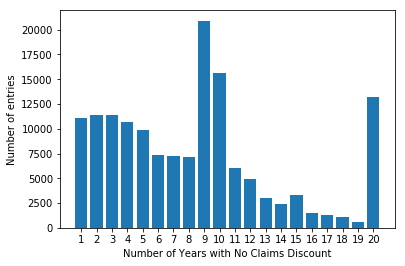

In [6]:
# Turn 'NCD' column to column of integers
df['NCD_int'] = [int(df['NCD'][i].split()[0]) for i in range(len(df))]


# Turn features that are segmented into cathegorical variables
NCDCathegories = np.sort(np.array(df['NCD_int'].unique()).astype(int))
columnsForTrain.append('NCD_int')

hist_NCD = {NCDCathegories[i]:len(df.loc[df['NCD_int'] == NCDCathegories[i]]) for i in range(len(NCDCathegories))}

plt.bar(hist_NCD.keys(), hist_NCD.values())
plt.xticks(NCDCathegories)
plt.xlabel('Number of Years with No Claims Discount')
plt.ylabel('Number of entries')
plt.savefig('HistogramOfNCDCat.png')

In [7]:
SegmentCat = df['Segment'].unique()
SegmentCat.sort()

# Turn features that are discrete into cathegorical variables
map_SegmentCat = {SegmentCat[i]:i for i in range(len(SegmentCat))}
df['SegmentCat'] = df['Segment'].map(map_SegmentCat)
columnsForTrain.append('SegmentCat')
del map_SegmentCat

Sorted values are:
['0-499', '500-999', '1000-1999', '2000-2999', '3000-4999', '5000-7499', '7500-9999', '10000-14999', '15000-19999', '20000+']


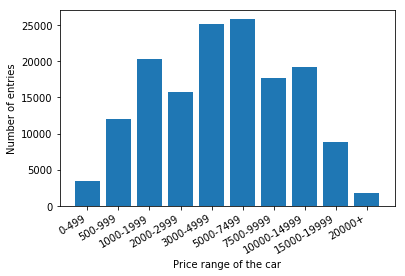

In [8]:
ValueCat = df['Vehicle_Value'].unique()
# Sort array by first integer appearing in each element
ValueCat = sorted(ValueCat, key=lambda x: float(x.replace('+','').split('-')[0]))
print('Sorted values are:')
print(ValueCat)

# Turn features that are discrete into cathegorical variables
map_ValueCat = {ValueCat[i]:i for i in range(len(ValueCat))}
df['ValueCat'] = df['Vehicle_Value'].map(map_ValueCat)
columnsForTrain.append('ValueCat')
del map_ValueCat

# Visualise the distribution
hist_Val = {ValueCat[i]:len(df.loc[df['Vehicle_Value'] == ValueCat[i]]) for i in range(len(ValueCat))}

fig = plt.figure()
plt.bar(hist_Val.keys(), hist_Val.values())
plt.xticks(ValueCat)
plt.xlabel('Price range of the car')
plt.ylabel('Number of entries')
fig.autofmt_xdate()
plt.savefig('HistogramOfPriceCat.png')



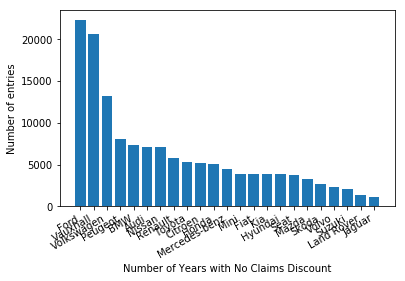

In [9]:
ManCat = df['Vehicle_Manufacturer'].unique()
# Turn features that are discrete into cathegorical variables
map_ManCat = {ManCat[i]:i for i in range(len(ManCat))}
df['ManCat'] = df['Vehicle_Manufacturer'].map(map_ManCat)
columnsForTrain.append('ManCat')
del map_ManCat

# Visualise the distribution
hist_Man = {ManCat[i]:len(df.loc[df['Vehicle_Manufacturer'] == ManCat[i]]) for i in range(len(ManCat))}
hist_Man = {k: v for k, v in sorted(hist_Man.items(), key=lambda x: x[1],  reverse=True)}

# Apply cut on values of the dictionary to be plotted (>50 entries)
hist_Man_forPlot = dict([[key, val] for key, val in hist_Man.items() if val>1000])

fig = plt.figure()
plt.bar(hist_Man_forPlot.keys(), hist_Man_forPlot.values())
plt.xticks(list(hist_Man_forPlot.keys()))
plt.xlabel('Number of Years with No Claims Discount')
plt.ylabel('Number of entries')
fig.autofmt_xdate()
plt.savefig('HistogramOfManufacturerCatReduced.png')


# Having seen the distribution, let's sort the manufacturers by how many times they apear in the data
# It is clear that for some manufaturers the statistics is too low to infer any useful information

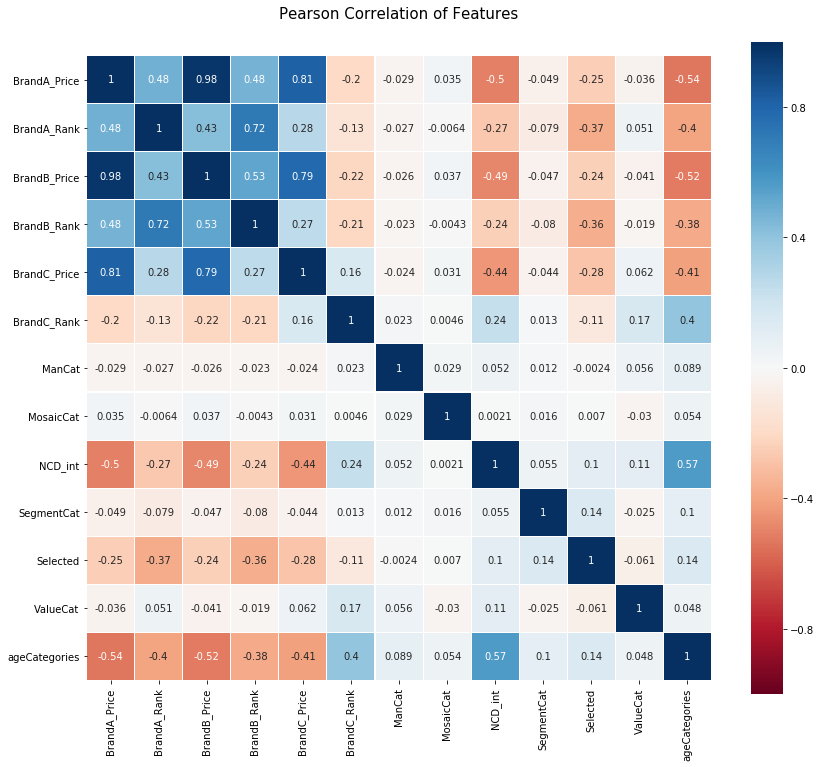

In [10]:
# Add a column flagging customers who selected an insurance through 
df['Selected'] = df['BrandA_Selected']+df['BrandB_Selected']+df['BrandC_Selected']
columnsForTrain.extend(('BrandA_Price','BrandA_Rank','BrandB_Price','BrandB_Rank',
                        'BrandC_Price','BrandC_Rank'))
columnsForTrain = sorted(list(set(columnsForTrain)))


# Now look at the correlations between the new variables created
columnsCorr = columnsForTrain
columnsCorr.append('Selected')
columnsCorr = sorted(list(set(columnsCorr)))
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df[columnsCorr].astype(float).corr(),linewidths=0.1,vmax=1.0,vmin=-1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.savefig('CorrelationFactors.png',format='png')
del columnsCorr
# Only correlations worthed to check are between the Brand price/rank, which is boring.. 
# However, this also means that each feature carries with it some unique information about the dataset.
# My biggest concern now is what way should I feed in variables such as Segment, Mosaic or the Manufacturer,
# because these are cathegorical features which have no natural order to be sorted by.
# I expect a powefull deep NN to be able to deal with this, but still..

The only reasonable correlations are between the features that are related to the three Brands and the column 'Selected'.
There is also an interesting correlation between the NCD column and the Brand's features. However, this is not reflected in the 'Selected' column, with an almost null correlation.

At the same time, we observe that BrandC's rank is much less correlated to everything else. However, it's price is still well correlated with customer's choice ('Selected'). This probably means that BrandC is somewhat different from the other two.

In [ ]:
# Might want to skip this part because it takes several minutes to run

# Another nice way to visualise the correlations is by plotting 2D histograms
ans = 'NotAssigned'
while ((ans != 'y') and (ans != 'n')):
    ans = input('The following code is quite computationally expensive. Do you want to run it? (y/n)')
if(ans=='y'):
    g = sns.pairplot(df[columnsForTrain].astype(float), palette = 'seismic',height=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
    g.set(xticklabels=[])
else:
    pass

The accuracy is: 76.11 %
[[42617  7345]
 [10670 14368]]


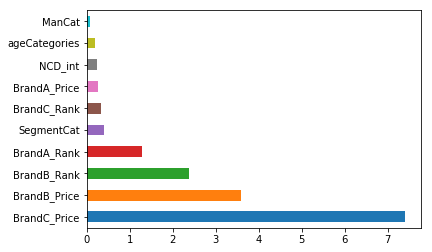

In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
try:
    columnsForTrain.remove('Selected')
except:
    pass
X = np.array(df[columnsForTrain])
y = np.array(df['Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')

print(confusion_matrix(y_test, y_pred))

So far, we did data cleaning and a very rought feature engineering. Further on, we tried a simple logistic regression to see how well does the customer-related data predict the likelyness of the customer to choose one of the brands presented.
The accuracy of the ML algorithm is not great (76%). We definitelly expected this since there is little to no correlation between the final decision and almost all information related to customers (e.g. Mosaic_Group, Vehicle_Value, etc.)


There are many ways to continue. One would be to do a more in-depth feature engineering to extract information about the customers that choose to get insured with one of the 3 brands.

In [13]:
# How many customers select an insurance?
numberInsured = df['Selected'][df['Selected']>0].count()
# 50k looks like a fictive input from the assessors :)

# How many per each brand
numberInsuredA = df['BrandA_Selected'][df['BrandA_Selected']>0].count()
numberInsuredB = df['BrandB_Selected'][df['BrandB_Selected']>0].count()
numberInsuredC = df['BrandC_Selected'][df['BrandC_Selected']>0].count()
print('Number of customers of Brand A is: '+str(numberInsuredA))
print('Number of customers of Brand A is: '+str(numberInsuredB))
print('Number of customers of Brand A is: '+str(numberInsuredC))

Number of customers of Brand A is: 4004
Number of customers of Brand A is: 26448
Number of customers of Brand A is: 19548


The brand A is doing much worse than the other two. We have to investigate why this is happening.

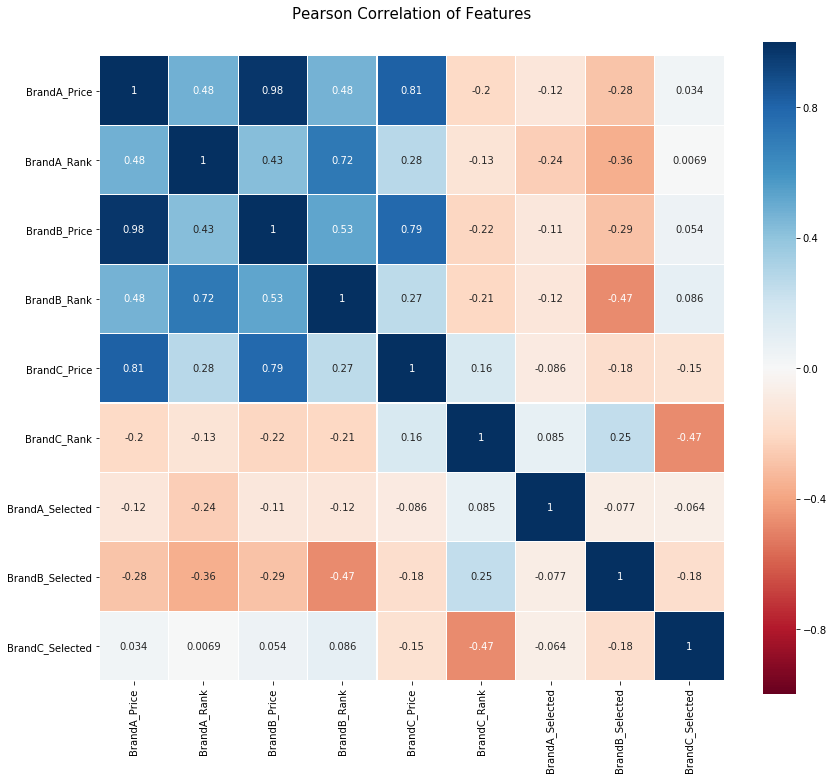

In [14]:
# Since we like them much, let's look again at the correlation matrix for some specific features

columnsCorr = ['BrandA_Price','BrandA_Rank','BrandB_Price','BrandB_Rank','BrandC_Price',
               'BrandC_Rank','BrandA_Selected','BrandB_Selected','BrandC_Selected',]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df[columnsCorr].astype(float).corr(),linewidths=0.1,vmax=1.0,vmin=-1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.savefig('CorrelationFactorsBrands.png',format='png')
del columnsCorr


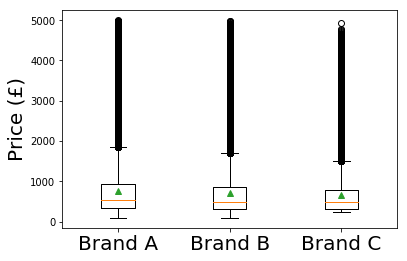

In [15]:
# To investigate further, let's see how the price of each brand

fig = plt.figure()
plt.boxplot([df['BrandA_Price'],df['BrandB_Price'],df['BrandC_Price']],showmeans=True)
plt.xticks([1, 2, 3],['Brand A','Brand B','Brand C'],fontsize=20)
plt.ylabel('Price (£)',fontsize=20)
fig.savefig('BoxPlotsofPrices',format='png')

The prices look very similar among each other with a lot of outliers each (prices way higher than mean).
I doubt we can extract any additional information from these distributions separately, so let's look at a feature that combines the distributions and tells us, for a class of customers, how each of the 3 brands are making their offers.

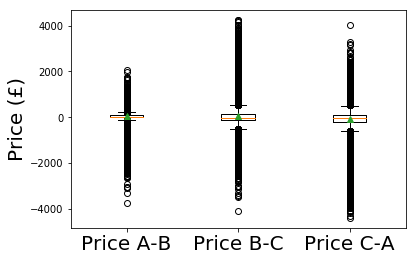

In [16]:
# Maybe price difference will tell us more

df['diffPriceAB'] = df['BrandA_Price']-df['BrandB_Price']
df['diffPriceBC'] = df['BrandB_Price']-df['BrandC_Price']
df['diffPriceCA'] = df['BrandC_Price']-df['BrandA_Price']

plt.boxplot([df['diffPriceAB'],df['diffPriceBC'],df['diffPriceCA']],showmeans=True)
plt.xticks([1, 2, 3],['Price A-B','Price B-C','Price C-A'],fontsize=20)
plt.ylabel('Price (£)',fontsize=20)
fig.savefig('BoxPlotsofPriceDiffs',format='png')

Ok, this is becoming more and more entertaining...

Although the 3 brands have about the same prices in general, it is clear that some of them (Brands B and C) manage to target their customers better than others (Brand A), resulting in more sales.
The only other feature related to each brand we have is the ranking. Before investigating each brand's targeting strategy, let's look at how the distribtions of rankings look like.

Seems like BrandB_Selected depends quite strongly on the rank of brand B in the search. However, that is already strongly correlated with brandA rank. Let's look more closelly at how the ranks of the three brands differ from each other using a box plot.

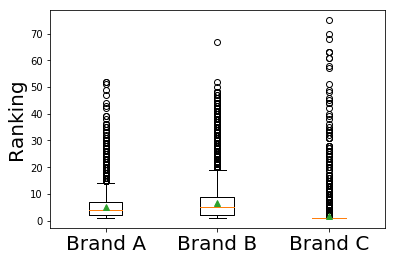

In [17]:
fig = plt.figure()
plt.boxplot([df['BrandA_Rank'][df['BrandA_Selected']==1],df['BrandB_Rank'][df['BrandB_Selected']==1]
             ,df['BrandC_Rank'][df['BrandC_Selected']==1]],showmeans=True)
plt.xticks([1, 2, 3],['Brand A','Brand B','Brand C'],fontsize=20)
plt.ylabel('Ranking',fontsize=20)
fig.savefig('BoxPlotsofRankings',format='png')


The above figure shows that the majority of Brand C sales are made for offers where they were ranked on the very top of the search results.

Now let's look at how the difference in ranking of the 3 brands affects customer's decision.
To do so, we will change the focus from the whole dataset (df) to a new one which only contains those customers who ended up making an insurance with one of the 3 brands

In [18]:
# Start by creating a new dataframe only containing the entries for which the customers opted for an insurance
df_insured = df[df['Selected']==True]

# Let's get some numbers out:
rankbest = np.argmin(np.array(df_insured[['BrandA_Rank','BrandB_Rank','BrandC_Rank']]),axis=1)
print('The percentage of each brand being ranked first is:')
print('Brand A : '+str(100*np.count_nonzero(rankbest == 0)/numberInsured)+' %')
print('Brand B : '+str(100*np.count_nonzero(rankbest == 1)/numberInsured)+' %')
print('Brand C : '+str(100*np.count_nonzero(rankbest == 2)/numberInsured)+' %')


The percentage of each brand being ranked first is:
Brand A : 14.078 %
Brand B : 44.05 %
Brand C : 41.872 %


This last result might explain why brand A is not making a lot of sales -> It rarely ranks first compared to brands B and C.

However, we might be looking in the wrong direction. So far, we only checked sales, but what's more important for the business is revenue (= sales * mean price)

In [19]:
# Compute the revenue of each brand
revenueA = (df_insured['BrandA_Selected']*df_insured['BrandA_Price']).sum()
revenueB = (df_insured['BrandB_Selected']*df_insured['BrandB_Price']).sum()
revenueC = (df_insured['BrandC_Selected']*df_insured['BrandC_Price']).sum()
print('Revenue of A is: '+str(round(revenueA/1000000,2))+' milion pounds')
print('Revenue of B is: '+str(round(revenueB/1000000,2))+' milion pounds')
print('Revenue of C is: '+str(round(revenueC/1000000,2))+' milion pounds')

Revenue of A is: 1.08 milion pounds
Revenue of B is: 8.2 milion pounds
Revenue of C is: 9.06 milion pounds


It now became clear. If there is somebody we want to be like, that is brand B and brand C. Now, let's see what are they doing different.


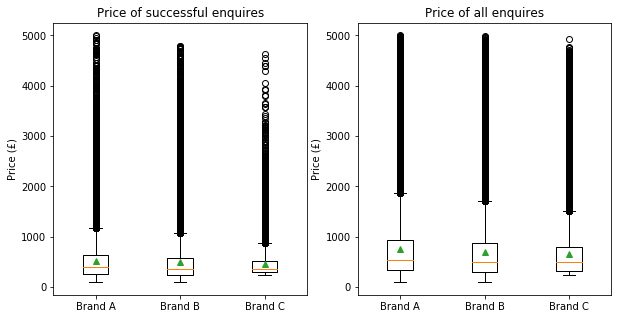

In [20]:
# Let's start by looking at the distribution of prices for each brand restricted to those customers who chose the brand
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot([df_insured['BrandA_Price'],df_insured['BrandB_Price'],df_insured['BrandC_Price']],showmeans=True)
ax[0].title.set_text('Price of successful enquires')


ax[1].boxplot([df['BrandA_Price'],df['BrandB_Price'],df['BrandC_Price']],showmeans=True)
plt.setp(ax, xticks=[1, 2, 3], xticklabels=['Brand A','Brand B','Brand C'],ylabel='Price (£)')
ax[1].title.set_text('Price of all enquires')
fig.savefig('BoxPlotsofPrices_CompbyInsured',format='png')

These plots do not provide loads of information. All we can learn is that the quoted price of the insurance is an important factor in customer's choice. This is because distributions of prices for the brands tend towards lower values for the dataset of accepted quotes. But again, that is something we could have guessed.

Before going back to the customer-related features, we will do one last test: Let's see how often each brand quotes the lowest price:

In [21]:
priceBest = np.argmin(np.array(df_insured[['BrandA_Price','BrandB_Price','BrandC_Price']]),axis=1)
print('The percentage of each brand quoting lowest price is:')
print('Brand A : '+str(100*np.count_nonzero(priceBest == 0)/numberInsured)+' %')
print('Brand B : '+str(100*np.count_nonzero(priceBest == 1)/numberInsured)+' %')
print('Brand C : '+str(100*np.count_nonzero(priceBest == 2)/numberInsured)+' %')

The percentage of each brand quoting lowest price is:
Brand A : 14.078 %
Brand B : 44.05 %
Brand C : 41.872 %


These last results show that it is very likelly that the ranking system is higly dependent on the price quoted by each brand.

In [22]:
checkAboveStatement = (rankbest==priceBest)
print([i for i, x in enumerate(checkAboveStatement) if not x])
# Since list printed is null the above statement is true-> extend the check over the whole dataset:

rankBestWhole = np.argmin(np.array(df[['BrandA_Price','BrandB_Price','BrandC_Price']]),axis=1)
priceBestWhole = np.argmin(np.array(df[['BrandA_Price','BrandB_Price','BrandC_Price']]),axis=1)

checkAboveStatementWhole = (rankbest==priceBest)
print('If following list is null then the price dictates the rank of each brand:')
print([i for i, x in enumerate(checkAboveStatementWhole) if not x])

[]
If following list is null then the price dictates the rank of each brand:
[]


Soo, we found that the ranking is just a redundant feature for the price quoted. However, this does not say anything about the behaviour of customers with respect to the other brands which were not included in the dataset.

Now, let's remind ourselves why did we look at all these: to answer the question "Why is brand A doing so much worse?". Did we answer it? Well, considering the number of times brand A quotes a lower price this behaviour can be partly explained. Why only partly? Because the percentage of customers brand A gets is 4004/50000 = 8% while the percentage of times the brand offers a lower price is 14 %. Where is the difference? That is what we aim at answering next.

##  Revisiting the customer-related features

We will now look at the same distributions as before, but we will this time be interested in the PCW customers that bought an insurance as a percentage of the customers that obtained a quote.


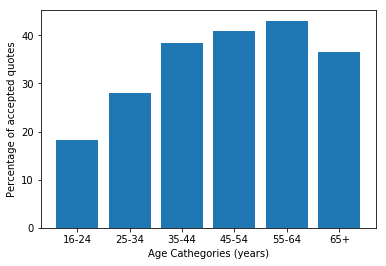

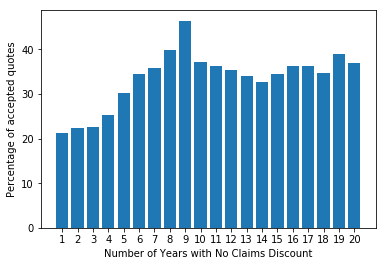

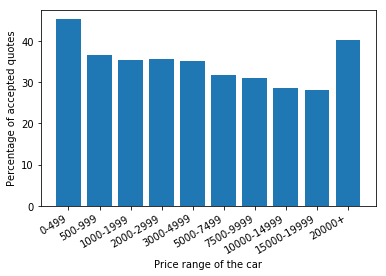

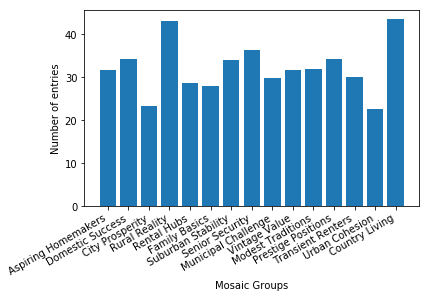

In [23]:
hist_age_insured = {ageCathegories[i]:len(df_insured.loc[df_insured['Age_Band'] == ageCathegories[i]]) for i in range(len(ageCathegories))}

hist_age_percentage_vals = 100*np.array(list(hist_age_insured.values()))/np.array(list(hist_age.values()))
fig = plt.figure()
plt.bar(hist_age_insured.keys(), hist_age_percentage_vals)
plt.xlabel('Age Cathegories (years)')
plt.ylabel('Percentage of accepted quotes')
plt.savefig('HistogramOfAgeCatInsuredPercentage.png')


hist_NCD_insured = {NCDCathegories[i]:len(df_insured.loc[df_insured['NCD_int'] == NCDCathegories[i]]) for i in range(len(NCDCathegories))}
hist_NCD_percentage_vals = 100*np.array(list(hist_NCD_insured.values()))/np.array(list(hist_NCD.values()))
fig = plt.figure()
plt.bar(hist_NCD.keys(), hist_NCD_percentage_vals)
plt.xticks(NCDCathegories)
plt.xlabel('Number of Years with No Claims Discount')
plt.ylabel('Percentage of accepted quotes')
plt.savefig('HistogramOfNCDInsuredPercentage.png')

hist_Val_insured = {ValueCat[i]:len(df_insured.loc[df_insured['Vehicle_Value'] == ValueCat[i]]) for i in range(len(ValueCat))}
hist_Val_percentage_vals = 100*np.array(list(hist_Val_insured.values()))/np.array(list(hist_Val.values()))


fig = plt.figure()
plt.bar(hist_Val.keys(), hist_Val_percentage_vals)
plt.xticks(ValueCat)
plt.xlabel('Price range of the car')
plt.ylabel('Percentage of accepted quotes')
fig.autofmt_xdate()
plt.savefig('HistogramOfPriceInsuredPercentage.png')

hist_Mosaic_insured = {MosaicCat[i]:len(df_insured.loc[df_insured['Mosaic_Group'] == MosaicCat[i]]) for i in range(len(MosaicCat))}
hist_Mosaic_percentage_vals = 100*np.array(list(hist_Mosaic_insured.values()))/np.array(list(hist_Mosaic.values()))


fig = plt.figure()
plt.bar(hist_Mosaic.keys(), hist_Mosaic_percentage_vals)
fig.autofmt_xdate()
plt.xlabel('Mosaic Groups')
plt.ylabel('Number of entries')
plt.savefig('HistogramOfMosaicInsuredPercentage.png')




#### Insights
The customers aged between 44-54 years, those with clean records for the last 9 years, those with cars costing less than 500 or above 20 000 pounds and those living in rural areas are more likelly to accept an offer. How much more? A few percentage points. Is this enough to benefit targeted approaches? Maybe..

But let's not forget the whole picture. These are features that influence each other and it is the combination of them the one that leads to the decision of one visitor to become a customer.

Let's try another logistic regression, but this time, one that only takes into consideration the customer-related features:





/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 68.52 %
f1 Score = 0.15


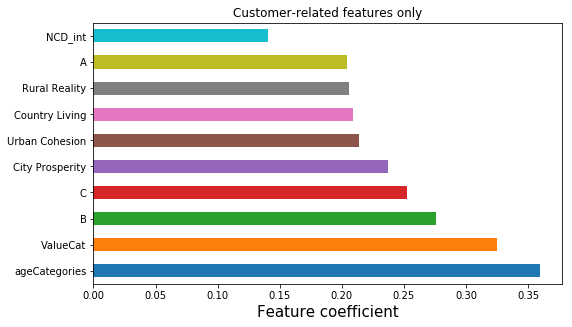

In [65]:
# Eliminate features related to the Brands.png
for i in range(len(columnsForTrain)):
    if(columnsForTrain[len(columnsForTrain)-1-i][0:5] == 'Brand'):
        del columnsForTrain[len(columnsForTrain)-1-i]
        
# Create new columns for each unique entry of the Mosaic_Group feature
for element in MosaicCat:
    df[element] = (df['Mosaic_Group']==element)
    
columnsForTrain.extend(MosaicCat)
columnsForTrain = list(set(columnsForTrain))

# Create new columns for each unique entry of the Segment feature
segmentCat = df['Segment'].unique()
segmentCat.sort()
for element in segmentCat:
    df[element] = (df['Segment']==element)
    
columnsForTrain.extend(segmentCat)
columnsForTrain = list(set(columnsForTrain))

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

X = np.array(df[columnsForTrain])
y = np.array(df['Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = f1_score(y_pred,y_train)
print('f1 Score = '+str(round(f1Score,2)))

fig = plt.figure(figsize= [8.4, 4.8])
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature coefficient',fontsize=15)
plt.title('Customer-related features only')
plt.savefig('final/FeatureImportanceOverallnoBrandfeatures.png',format='png')

/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 69.65 %
f1 Score = 0.18


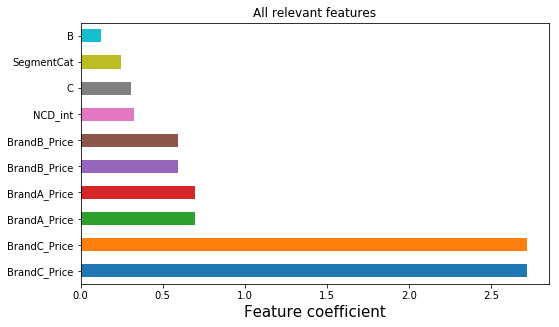

In [63]:
# Let's do the same as above but include 3 new features: the price offered by each of the three brands
columnsForTrain.extend(('BrandA_Price','BrandB_Price','BrandC_Price'))
X = np.array(df[columnsForTrain])
y = np.array(df['Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = f1_score(y_pred,y_train)
print('f1 Score = '+str(round(f1Score,2)))

fig = plt.figure(figsize= [8.4, 4.8])
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature coefficient',fontsize=15)
plt.title('All relevant features')
plt.savefig('final/FeatureImportanceOverallwithBrandfeatures.png',format='png')

/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 69.48 %


/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 69.7 %


/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 69.59 %


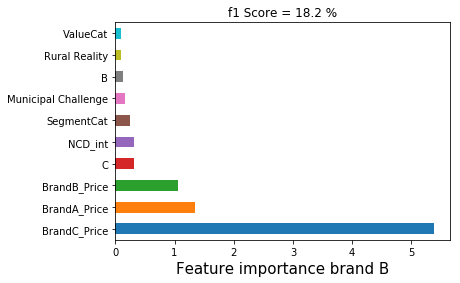

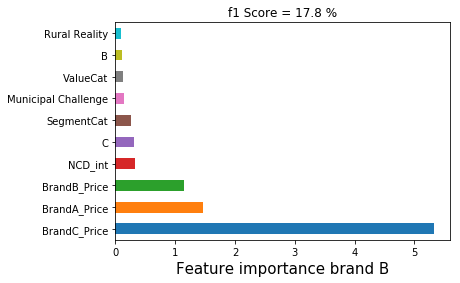

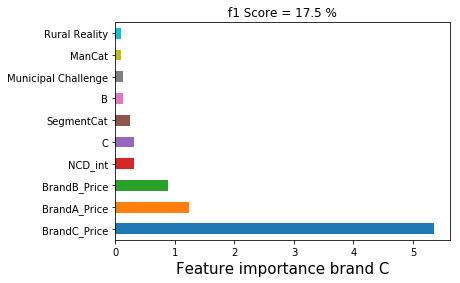

In [26]:
# Previous results were discouraging. Maybe we are not looking in the right direction.
# Maybe rather than predicting when a customer will choose a product, we should look at how each brand attracts their
# customers and train the logistic regression with respect to that
columnsForTrain.extend(('BrandA_Price','BrandB_Price','BrandC_Price'))
columnsForTrain = list(set(columnsForTrain))
X = np.array(df[columnsForTrain])
y_A = np.array(df['BrandA_Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = 100 * f1_score(y_pred,y_train)

fig = plt.figure()
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance brand B',fontsize=15)
plt.title('f1 Score = '+str(round(f1Score,1))+' %')
plt.savefig('FeatureImportanceABrand.png',format='png')


#########################################################################################
columnsForTrain.extend(('BrandA_Price','BrandB_Price','BrandC_Price'))
columnsForTrain = list(set(columnsForTrain))
X = np.array(df[columnsForTrain])
y_A = np.array(df['BrandB_Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = 100 * f1_score(y_pred,y_train)

fig = plt.figure()
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance brand B',fontsize=15)
plt.title('f1 Score = '+str(round(f1Score,1))+' %')
plt.savefig('FeatureImportanceBBrand.png',format='png')

##################################################################################################
columnsForTrain.extend(('BrandA_Price','BrandB_Price','BrandC_Price'))
columnsForTrain = list(set(columnsForTrain))
X = np.array(df[columnsForTrain])
y_A = np.array(df['BrandC_Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = 100 * f1_score(y_pred,y_train)

fig = plt.figure()
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature importance brand C',fontsize=15)
plt.title('f1 Score = '+str(round(f1Score,1))+' %')
plt.savefig('FeatureImportanceCBrand.png',format='png')

/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The accuracy is: 76.14 %


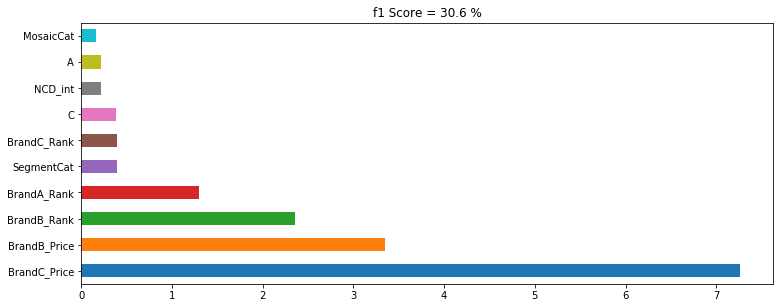

In [57]:
# Although we showed that the rank of each brand is redundant for the price quoted, let's input the ranking
# features in the ML algorithm as well to see how much better we can do
# Let's do the same as above but include 3 new features: the price offered by each of the three brands
columnsForTrain.extend(('BrandA_Price','BrandB_Price','BrandC_Price','BrandA_Rank','BrandB_Rank','BrandC_Rank'))
columnsForTrain = sorted(list(set(columnsForTrain)))
X = np.array(df[columnsForTrain])
y = np.array(df['Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)



logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('The accuracy is: '+str(acc_log)+' %')

# Compute f1 score
from sklearn.metrics import f1_score
f1Score = 100 * f1_score(y_pred,y_train)

fig = plt.figure(figsize= [12.4, 4.8])
feat_importances = pd.Series(np.abs(np.array(logreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('f1 Score = '+str(round(f1Score,1))+' %')
plt.savefig('FeatureImportanceOverallAllfeatures.png',format='png')

Previous result is somewhat better than what we had before. However, there is still a long way to go before we can infer something useful from a targeted approach. It might be that a more powerfull algorithm is required which would be able to depict non-linear correlations between the current features.

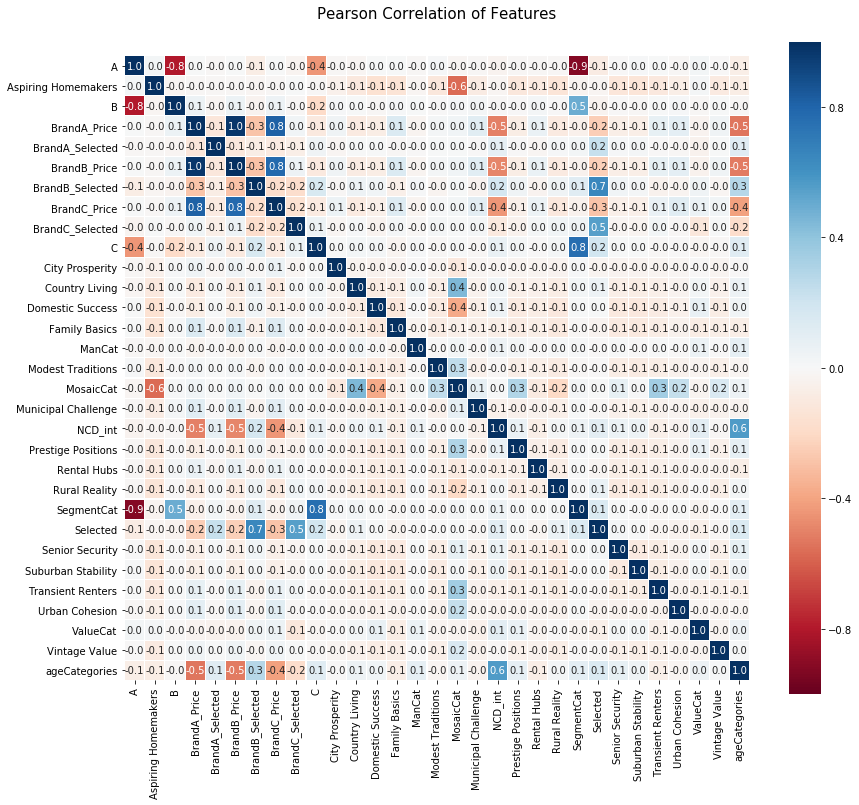

In [28]:
# Another (hopefully last) correlation map
# Eliminate features related to the Brands
for i in range(len(columnsForTrain)):
    if(columnsForTrain[len(columnsForTrain)-1-i][0:5] == 'Brand'):
        del columnsForTrain[len(columnsForTrain)-1-i]

columnsCorr = columnsForTrain
columnsCorr.extend(('Selected','BrandA_Selected','BrandB_Selected','BrandC_Selected'))
columnsCorr = sorted(list(set(columnsCorr)))
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df[columnsCorr].astype(float).corr(),linewidths=0.1,vmax=1.0,vmin=-1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True,fmt='.1f')
plt.savefig('CorrelationFactorLAST.png',format='png')


In the previous lines we showed that the car insurance market is competitive and the final customer choice is highly correlated with the price quoted by a brand and its somewhat redundant feature 'ranking'.

We now want to test this hypothesis from the customer's perspective and answer the following question:
Is the quoted price solely the only reason for chosing an insurance or does the brand matter?

In [29]:
# Create a numpy array representing the brand chosen
choice = np.zeros(len(df_insured),dtype=int)
choice = choice + df_insured['BrandB_Selected']+2*df_insured['BrandC_Selected']
choice
# Check how this correlates with the brand that offered minimum price
print('The percentage of times the final choice was not solely based on price was: '+
      str(round(100*sum(choice-priceBest)/numberInsured,2))+' %')

The percentage of times the final choice was not solely based on price was: 3.29 %


In [30]:
df_insured['NotMinPrice'] = np.abs(choice-priceBest)>0

/home/vladgriguta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
# Now look at which brand was chosen by these customers and how much revenue was made

brandAorganicSales = df_insured['BrandA_Selected'][df_insured['NotMinPrice'] == True].count()
brandAorganicRevenue = (df_insured['BrandA_Selected'][df_insured['NotMinPrice'] == True]*df_insured['BrandA_Price'][df_insured['NotMinPrice'] == True]).sum()

brandBorganicSales = df_insured['BrandB_Selected'][df_insured['NotMinPrice'] == True].count()
brandBorganicRevenue = (df_insured['BrandB_Selected'][df_insured['NotMinPrice'] == True]*df_insured['BrandB_Price'][df_insured['NotMinPrice'] == True]).sum()

brandCorganicSales = df_insured['BrandC_Selected'][df_insured['NotMinPrice'] == True].count()
brandCorganicRevenue = (df_insured['BrandC_Selected'][df_insured['NotMinPrice'] == True]*df_insured['BrandC_Price'][df_insured['NotMinPrice'] == True]).sum()

print('Brand A obtained '+str(brandAorganicSales)+' organic sales with a revenue of '
      +str(int(round(brandAorganicRevenue)))+' pounds')

print('Brand B obtained '+str(brandBorganicSales)+' organic sales with a revenue of '
      +str(int(round(brandBorganicRevenue)))+' pounds')

print('Brand C obtained '+str(brandCorganicSales)+' organic sales with a revenue of '
      +str(int(round(brandCorganicRevenue)))+' pounds')
print('Total revenue is: '+str(int(round(brandAorganicRevenue+brandBorganicRevenue+brandCorganicRevenue))))

Brand A obtained 5339 organic sales with a revenue of 156010 pounds
Brand B obtained 5339 organic sales with a revenue of 1371504 pounds
Brand C obtained 5339 organic sales with a revenue of 47203 pounds
Total revenue is: 1574717.1800000002


The number of 'organic' (not determined by price) sales made by each brand is exactly the same. This is strong evidence for the fact that the organic sales are equally distributed among the brands.

#### We will leave this as a conclusion for the brand-related features: only price matters

Let's take this outcome back to our aim: develop a product using a segmented approach. If only the price matters, there is no room for a segmented approach.

However, there is plenty of room for suggesting a price that is better than what competition offers. How? Regression algorithm:

/home/vladgriguta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/vladgriguta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/vladgriguta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Mean squared error: 26941.57853114
The coefficient of determination is: R^2=0.36449752667856306


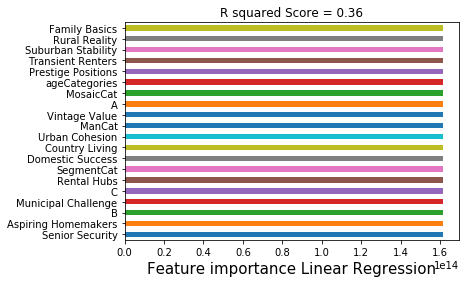

In [45]:

# Eliminate features related to the Brands
for i in range(len(columnsForTrain)):
    if(columnsForTrain[len(columnsForTrain)-1-i][0:5] == 'Brand'):
        del columnsForTrain[len(columnsForTrain)-1-i]
columnsForTrain.remove('Selected')


# Create new columns for each unique entry of the Mosaic_Group feature
for element in MosaicCat:
    df_insured[element] = (df_insured['Mosaic_Group']==element)
    
columnsForTrain.extend(MosaicCat)
columnsForTrain = list(set(columnsForTrain))

# Create new columns for each unique entry of the Segment feature
segmentCat = df_insured['Segment'].unique()
segmentCat.sort()
for element in segmentCat:
    df_insured[element] = (df_insured['Segment']==element)
columnsForTrain.extend(segmentCat)
columnsForTrain = list(set(columnsForTrain))

columnsForTrainLinear = ['SegmentCat','ManCat','MosaicCat','ageCategories','NCD_int','ValueCat']  
    
X = np.array(df_insured[columnsForTrain])
y = np.array(df_insured['BrandA_Price']*df_insured['BrandA_Selected']+
            df_insured['BrandB_Price']*df_insured['BrandB_Selected']+
            df_insured['BrandC_Price']*df_insured['BrandC_Selected'])

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)
R = r2_score(y_test, y_pred)
print("Mean squared error: "+str(mean_squared_error(y_test, y_pred)))
print('The coefficient of determination is: R^2='+str(R))

fig = plt.figure()
feat_importances = pd.Series(np.abs(np.array(linreg.coef_[0])), index=columnsForTrain)
feat_importances.nlargest(20).plot(kind='barh')
plt.xlabel('Feature importance Linear Regression',fontsize=15)
plt.title('R squared Score = '+str(round(R,2)))
plt.savefig('FeatureImportanceLinearReg.png',format='png')

In [44]:
X

array([[ 0,  2,  7,  1,  2,  6],
       [ 0,  3,  8,  1,  8,  1],
       [ 1, 21,  7,  4, 15,  6],
       ...,
       [ 2,  3, 13,  1,  3,  4],
       [ 0,  7, 11,  2, 20,  9],
       [ 2,  0,  3,  1,  7,  1]], dtype=int64)

In [39]:
X_train.shape

(25000, 25)